![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 2D CNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn2D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework

In [5]:
#-- Record figures during training:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR10 dataset:

In [6]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

#### Plot some examples:

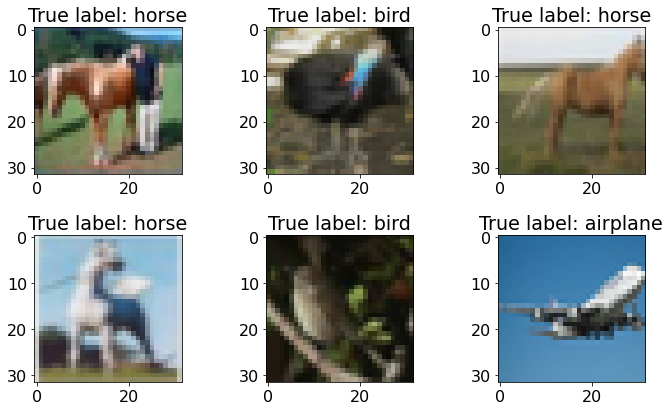

In [7]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [8]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std (axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [9]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [10]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

#### Define the model (2D CNN):

In [11]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary
   
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (C, H, W), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 30, 30, 30]             810
       BatchNorm2d-3           [-1, 30, 30, 30]              60
              ReLU-4           [-1, 30, 30, 30]               0
         Dropout2d-5           [-1, 30, 30, 30]               0
            Conv2d-6           [-1, 60, 28, 28]          16,200
         MaxPool2d-7           [-1, 60, 14, 14]               0
       BatchNorm2d-8           [-1, 60, 14, 14]             120
              ReLU-9           [-1, 60, 14, 14]               0
        Dropout2d-10           [-1, 60, 14, 14]               0
           Conv2d-11          [-1, 120, 12, 12]          64,800
      BatchNorm2d-12          [-1, 120, 12, 12]             240
             ReLU-13          [-1, 120, 12, 12]               0
        Dropout2d-14          [-1, 120,

#### Check whether GPU is available:

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [14]:
oModel  = GetModel().to(DEVICE)
oOptim  = optim.AdamW(oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
Loss    = nn.CrossEntropyLoss()
nEpochs = 30

TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss:  1.672 | Val loss:  1.305 | Train Accuracy:  0.380 | Val Accuracy:  0.522 | epoch time:  8.449 | <-- Checkpoint!
Epoch 001: | Train loss:  1.256 | Val loss:  0.999 | Train Accuracy:  0.548 | Val Accuracy:  0.646 | epoch time:  7.022 | <-- Checkpoint!
Epoch 002: | Train loss:  1.064 | Val loss:  0.912 | Train Accuracy:  0.619 | Val Accuracy:  0.676 | epoch time:  7.038 | <-- Checkpoint!
Epoch 003: | Train loss:  0.945 | Val loss:  0.769 | Train Accuracy:  0.667 | Val Accuracy:  0.730 | epoch time:  7.008 | <-- Checkpoint!
Epoch 004: | Train loss:  0.858 | Val loss:  0.716 | Train Accuracy:  0.696 | Val Accuracy:  0.756 | epoch time:  7.068 | <-- Checkpoint!
Epoch 005: | Train loss:  0.788 | Val loss:  0.697 | Train Accuracy:  0.726 | Val Accuracy:  0.761 | epoch time:  7.183 | <-- Checkpoint!
Epoch 006: | Train loss:  0.731 | Val loss:  0.636 | Train Accuracy:  0.745 | Val Accuracy:  0.780 | epoch time:  7.140 | <-- Checkpoint!
Epoch 007: | Train loss:  0.688 | 

### Exercise
* Load the Fashion-MNIST dataset.
* Use 2D CNN, try to get the high accuracy (above 93% is good).

In [15]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

torch.Size([60000, 28, 28])

In [16]:
lClasses  = oTrainSet.classes
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

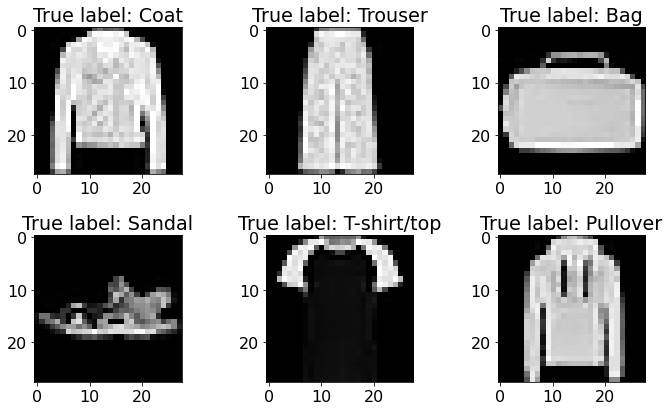

In [17]:
N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow   (mX.squeeze(), cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

In [25]:
???

Object `?` not found.


In [26]:
???

Object `??` not found.
